# Deep Q Network with Navigation

DQN was created by DeepMind researchers, achieving superhuman performance on many Atari games (https://deepmind.com/research/dqn/). What made the accomplishments of DQN even more impressive is that the DQN had nearly the same architecture and hyperparameter settings for each game (ie no game specific knowledge or set up) and the only inputs to the DQN were the screen pixels.

The main parts of the DQN are Q learning, the neural net, experience replay, target network updating, and data/environment pre-processing. For the neural net in this example, we replaced the Convolutional Neural Net (CNN) used in the original DQN with a 2 layer feed forward neural network (FFNN). We use the FFNN since CartPole doesn't give us image data. We'll use the CNN and data/environment pre-processing in the Pong DQN example


In [1]:
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)


import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
sys.path.append("/Users/rangamuv/deep-reinforcement-learning/python/")
from unityagents import UnityEnvironment

# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Experience Replay Buffer

Q learning is an off-policy method. In off-policy methods we often save samples and then train on them. DQN has a memory buffer that stores state, action, reward, done condition, and next state samples. In the training loop, DQN will sample from this memory buffer and train on the saved samples. The replay buffer is essentially a queue that we randomly sample from. When the queue gets full we replace the first element of the queue. 

In [2]:
# replay buffer from and some code based on https://github.com/sfujim/TD3

# create replay buffer of tuples of (state, next_state, action, reward, done)
class ReplayBuffer():
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind: 
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        
        return np.array(x), np.array(y), np.array(u).reshape(-1,1), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

###  DQN

In [3]:
import os
import sys

import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)


import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

sys.path.append("/Users/rangamuv/deep-reinforcement-learning/python/")
from unityagents import UnityEnvironment

# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# initialize environment
env = UnityEnvironment(file_name="/Users/rangamuv/deep-reinforcement-learning/Banana.app")


# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]


# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [1.    0.    0.    0.    0.844 0.    0.    1.    0.    0.075 0.    1.    0.    0.    0.258 1.    0.    0.    0.
 0.742 0.    1.    0.    0.    0.259 0.    0.    1.    0.    0.094 0.    1.    0.    0.    0.32  0.    0.   ]
States have length: 37


### Discretize

In [5]:
desc_size = 10000

In [6]:
low  = np.zeros(state_size)

high = np.ones(state_size)

bins      = [desc_size for x in range(state_size)]

In [7]:
def create_uniform_grid(low, high, bins = [desc_size for x in range(state_size)]):
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] for dim in range(len(bins))]
    return grid


In [8]:
grid = create_uniform_grid(low, high)

In [9]:
def discretize(array, grid):

    result =  np.array([int(np.digitize(s, g)) for s, g in zip(array, grid)])/desc_size  # apply along each dimension

    #result = array

    return result

In [14]:
%%writefile model.pt

import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, state_size)
        self.fc2 = nn.Linear(state_size, fc1_units)
        self.fc3 = nn.Linear(fc1_units, fc2_units)
        #self.fc4 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        return self.fc3(x)



Writing model.pt


In [11]:
import numpy as np
import random
from collections import namedtuple, deque


import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [12]:
scores = []
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.99):

    global scores                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset()[brain_name]
        state = discretize(env_info.vector_observations[0],grid)
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = discretize(env_info.vector_observations[0],grid)
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tEpsilon: {}\tAverage Score: {:.2f}'.format(i_episode, round(eps,2), np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tEpsilon: {}\tAverage Score: {:.2f}'.format(i_episode, round(eps,2), np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = Agent(state_size,action_size,42)

scores = dqn()


Episode 100	Epsilon: 0.36603234127322926	Average Score: 0.47
Episode 200	Epsilon: 0.13397967485796175	Average Score: 2.95
Episode 300	Epsilon: 0.04904089407128576	Average Score: 6.810
Episode 400	Epsilon: 0.017950553275045134	Average Score: 7.92
Episode 500	Epsilon: 0.01	Average Score: 9.84age Score: 8.965
Episode 600	Epsilon: 0.01	Average Score: 10.94
Episode 700	Epsilon: 0.01	Average Score: 11.78
Episode 775	Epsilon: 0.01	Average Score: 13.00
Environment solved in 675 episodes!	Average Score: 13.00


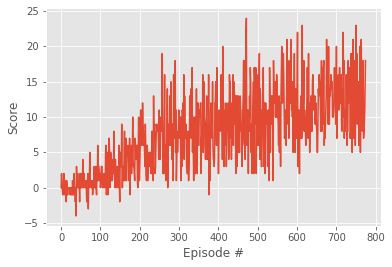

In [13]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()